# Distance and Language Similarity

### Imports

In [1298]:
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from textblob import TextBlob as tb
from contractions import CONTRACTION_MAP
stopwords = stopwords.words('english')
stopwords.remove('no')
stopwords.remove('not')

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, paired_cosine_distances
import spacy
nlp = spacy.load('en_core_web_sm')

import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx

In [1142]:
text = pd.read_csv('HE_texts.csv',index_col=None,header=0)
n = text.shape[0]

### Text Preprocessing

In [1143]:
text['length'] = text['text'].apply(len)
text['name'][3] = 'tanjangco'
text.head()

c:\users\limri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


text       name  length
0  Perhaps, I’ve seen society at its best and at ...       chan    1037
1  At the start of the game, we were clueless, be...    del_rio    2242
2  When a casual free-for-all card-game starts, m...        tan    2925
3  Last session, our class conducted a social exp...  tanjangco    3469
4  During the game of exploding kittens I realize...   cuartero    2485

##### Text Cleaning

In [1144]:
def clean_text(text):
    """
    Function for cleaning text based on class jupyter notebook on text manipulation
    """
    text['cleaned_text'] = text['text'].fillna('')
    text['cleaned_text'] = text['cleaned_text'].str.lower()
    text['cleaned_text'] = text['cleaned_text'].str.replace(r'([\.;,()\"“”])|', '')
    text['cleaned_text'] = text['cleaned_text'].str.replace(r'([-])', ' ')
    text['cleaned_text'] = text['cleaned_text'].str.replace(r'([’])', '\'')
    text['cleaned_text'] = text['cleaned_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in (stopwords)]))
    return text

In [1145]:
clean = clean_text(text)
clean.head()

text       name  length  \
0  Perhaps, I’ve seen society at its best and at ...       chan    1037   
1  At the start of the game, we were clueless, be...    del_rio    2242   
2  When a casual free-for-all card-game starts, m...        tan    2925   
3  Last session, our class conducted a social exp...  tanjangco    3469   
4  During the game of exploding kittens I realize...   cuartero    2485   

                                        cleaned_text  
0  perhaps i've seen society best worst social ex...  
1  start game clueless know play game still tryin...  
2  casual free card game starts often not players...  
3  last session class conducted social experiment...  
4  game exploding kittens realized way people thi...

##### Expanding Contractions

In [1146]:
'''
Contraction map from : towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72
Contraction expansion function from : gist.github.com/nealrs/96342d8231b75cf4bb82
'''

c_re = re.compile(r'\b(?:%s)\b' % '|'.join(CONTRACTION_MAP.keys()))

def expandContractions(text):
    def replace(match):
        return CONTRACTION_MAP[match.group(0)]
    return c_re.sub(replace, text)

In [1147]:
expand_list = []
for i in range(n):
    expand_list.append(expandContractions(clean.loc[i]['cleaned_text']))
clean['cleaned_text'] = expand_list
clean.head()

text       name  length  \
0  Perhaps, I’ve seen society at its best and at ...       chan    1037   
1  At the start of the game, we were clueless, be...    del_rio    2242   
2  When a casual free-for-all card-game starts, m...        tan    2925   
3  Last session, our class conducted a social exp...  tanjangco    3469   
4  During the game of exploding kittens I realize...   cuartero    2485   

                                        cleaned_text  
0  perhaps i have seen society best worst social ...  
1  start game clueless know play game still tryin...  
2  casual free card game starts often not players...  
3  last session class conducted social experiment...  
4  game exploding kittens realized way people thi...

In [1148]:
# cleaning again

def clean_text_2(text):
    text['expanded'] = text['cleaned_text'].fillna('')
    text['expanded'] = text['expanded'].str.replace(r'([\'])', '')
    text['expanded'] = text['expanded'].apply(lambda x: ' '.join([w for w in x.split() if w not in (stopwords)]))
    return text

expand = clean_text_2(text)
expand.head()

text       name  length  \
0  Perhaps, I’ve seen society at its best and at ...       chan    1037   
1  At the start of the game, we were clueless, be...    del_rio    2242   
2  When a casual free-for-all card-game starts, m...        tan    2925   
3  Last session, our class conducted a social exp...  tanjangco    3469   
4  During the game of exploding kittens I realize...   cuartero    2485   

                                        cleaned_text  \
0  perhaps i have seen society best worst social ...   
1  start game clueless know play game still tryin...   
2  casual free card game starts often not players...   
3  last session class conducted social experiment...   
4  game exploding kittens realized way people thi...   

                                            expanded  
0  perhaps seen society best worst social experim...  
1  start game clueless know play game still tryin...  
2  casual free card game starts often not players...  
3  last session class conducted social experiment...  
4  game exploding kittens realized way people thi...

##### Text Lemmatization

In [1149]:
def lemmatize():
    to_lemm = expand
    to_lemm['lemmatized'] = ''
    for i in range(0,len(to_lemm.index)):
        lemmatized = ''
        blob = tb(to_lemm['expanded'][i]).sentences[0]
        tags = blob.tags
        for j in range(0,len(tags)):
            if tags[j][1].startswith('NN'):
                lemmatized += tags[j][0].lemmatize('n')
                lemmatized += ' '
            elif tags[j][1].startswith('VB'):
                lemmatized += tags[j][0].lemmatize('v')
                lemmatized += ' '
            elif tags[j][1].startswith('JJ'):
                lemmatized += tags[j][0].lemmatize('a')
                lemmatized += ' '
            else:
                lemmatized += tags[j][0]
                lemmatized += ' '
        to_lemm['lemmatized'][i] = lemmatized.strip()
    return to_lemm

In [1150]:
lemm = lemmatize()
lemm.head()

c:\users\limri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


text       name  length  \
0  Perhaps, I’ve seen society at its best and at ...       chan    1037   
1  At the start of the game, we were clueless, be...    del_rio    2242   
2  When a casual free-for-all card-game starts, m...        tan    2925   
3  Last session, our class conducted a social exp...  tanjangco    3469   
4  During the game of exploding kittens I realize...   cuartero    2485   

                                        cleaned_text  \
0  perhaps i have seen society best worst social ...   
1  start game clueless know play game still tryin...   
2  casual free card game starts often not players...   
3  last session class conducted social experiment...   
4  game exploding kittens realized way people thi...   

                                            expanded  \
0  perhaps seen society best worst social experim...   
1  start game clueless know play game still tryin...   
2  casual free card game starts often not players...   
3  last session class conducted social experiment...   
4  game exploding kittens realized way people thi...   

                                          lemmatized  
0  perhaps see society best worst social experime...  
1  start game clueless know play game still try f...  
2  casual free card game start often not player p...  
3  last session class conduct social experiment u...  
4  game explode kitten realize way people think t...

## Sentiment Analysis

In [1151]:
def analyze_text(text):
    """
    Function for analyzing sentiment and subjectivity based on class jupyter notebook on text analysis
    """
    sentiment = []
    subjectivity = []
    for i in text['lemmatized']:
        blob = tb(i)
        sentiment.append(blob.polarity)
        subjectivity.append(blob.subjectivity)
    text['sentiment'] = sentiment
    text['subjectivity'] = subjectivity
    return text

In [1152]:
sent = analyze_text(lemm)
sent.head()

text       name  length  \
0  Perhaps, I’ve seen society at its best and at ...       chan    1037   
1  At the start of the game, we were clueless, be...    del_rio    2242   
2  When a casual free-for-all card-game starts, m...        tan    2925   
3  Last session, our class conducted a social exp...  tanjangco    3469   
4  During the game of exploding kittens I realize...   cuartero    2485   

                                        cleaned_text  \
0  perhaps i have seen society best worst social ...   
1  start game clueless know play game still tryin...   
2  casual free card game starts often not players...   
3  last session class conducted social experiment...   
4  game exploding kittens realized way people thi...   

                                            expanded  \
0  perhaps seen society best worst social experim...   
1  start game clueless know play game still tryin...   
2  casual free card game starts often not players...   
3  last session class conducted social experiment...   
4  game exploding kittens realized way people thi...   

                                          lemmatized  sentiment  subjectivity  
0  perhaps see society best worst social experime...   0.008824      0.385294  
1  start game clueless know play game still try f...  -0.032258      0.411751  
2  casual free card game start often not player p...  -0.020714      0.473155  
3  last session class conduct social experiment u...   0.002880      0.363518  
4  game explode kitten realize way people think t...  -0.022295      0.391788

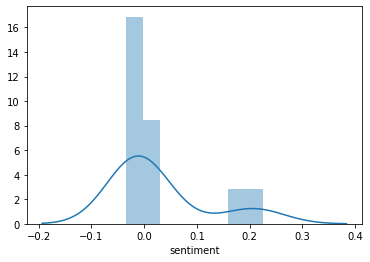

In [1153]:
sns.distplot(sent['sentiment'])

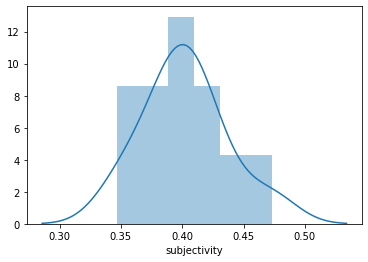

In [1154]:
sns.distplot(sent['subjectivity'])

## Text Similarity

In [1294]:
txt = sent[['name','length','lemmatized','sentiment','subjectivity']]
txt.head()

name  length                                         lemmatized  \
0       chan    1037  perhaps see society best worst social experime...   
1    del_rio    2242  start game clueless know play game still try f...   
2        tan    2925  casual free card game start often not player p...   
3  tanjangco    3469  last session class conduct social experiment u...   
4   cuartero    2485  game explode kitten realize way people think t...   

   sentiment  subjectivity  
0   0.008824      0.385294  
1  -0.032258      0.411751  
2  -0.020714      0.473155  
3   0.002880      0.363518  
4  -0.022295      0.391788

In [1156]:
sns.lmplot(data=txt, x='sentiment', y='subjectivity', fit_reg=True) 

In [1157]:
### AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
vect = TfidfVectorizer(min_df=1)
tfidf = vect.fit_transform(txt['lemmatized'])
euclidean = pd.DataFrame(euclidean_distances(tfidf))
euclidean.head()

0         1         2         3         4         5         6   \
0  0.000000  1.310911  1.258572  1.238306  1.232336  1.310458  1.246803   
1  1.310911  0.000000  1.250383  1.279143  1.157006  1.208408  1.212101   
2  1.258572  1.250383  0.000000  1.080770  1.187397  1.253806  1.202194   
3  1.238306  1.279143  1.080770  0.000000  1.147857  1.183203  1.134690   
4  1.232336  1.157006  1.187397  1.147857  0.000000  1.172112  1.144180   

         7         8         9         10  
0  1.286468  1.261391  1.233749  1.291935  
1  1.282713  1.242202  1.195485  1.290728  
2  1.136713  1.216461  1.183844  1.210034  
3  1.017258  1.157209  1.110680  1.081524  
4  1.221138  1.205253  1.087101  1.212352

In [1295]:
cosine = pd.DataFrame(cosine_similarity(tfidf))
cosine

0         1         2         3         4         5         6   \
0   1.000000  0.140757  0.207999  0.233300  0.240674  0.141350  0.222741   
1   0.140757  1.000000  0.218271  0.181897  0.330669  0.269875  0.265406   
2   0.207999  0.218271  1.000000  0.415969  0.295044  0.213986  0.277365   
3   0.233300  0.181897  0.415969  1.000000  0.341212  0.300015  0.356240   
4   0.240674  0.330669  0.295044  0.341212  1.000000  0.313077  0.345426   
5   0.141350  0.269875  0.213986  0.300015  0.313077  1.000000  0.331735   
6   0.222741  0.265406  0.277365  0.356240  0.345426  0.331735  1.000000   
7   0.172500  0.177323  0.353942  0.482593  0.254411  0.195743  0.303902   
8   0.204446  0.228467  0.260111  0.330434  0.273683  0.307763  0.317552   
9   0.238932  0.285407  0.299256  0.383195  0.409105  0.358626  0.458086   
10  0.165451  0.167011  0.267909  0.415153  0.265102  0.295958  0.340160   

          7         8         9         10  
0   0.172500  0.204446  0.238932  0.165451  
1   0.177323  0.228467  0.285407  0.167011  
2   0.353942  0.260111  0.299256  0.267909  
3   0.482593  0.330434  0.383195  0.415153  
4   0.254411  0.273683  0.409105  0.265102  
5   0.195743  0.307763  0.358626  0.295958  
6   0.303902  0.317552  0.458086  0.340160  
7   1.000000  0.338159  0.262747  0.446775  
8   0.338159  1.000000  0.281359  0.291617  
9   0.262747  0.281359  1.000000  0.351036  
10  0.446775  0.291617  0.351036  1.000000

## Social Network

In [1159]:
class_list = pd.read_csv('class_info.csv',index_col=None,header=0)

# handling missing values
class_list['top'].fillna(value="",inplace=True)
class_list['familiarity'].fillna(value="",inplace=True)
class_list['followed'].fillna(value=class_list['followed'].mean(),inplace=True)
class_list['followers'].fillna(value=class_list['followers'].mean(),inplace=True)

class_list.head()

name                                    orgs groupmate unicorn  \
0       chan            compsat, speed, ams, celadon        ng     two   
1    del_rio                          compsat, uxsoc       lim     one   
2        tan  misa, aea, patch, cuisina, writerskill     waley     one   
3  tanjangco                         compsat, aiesec     borja     two   
4   cuartero                        compsat, celadon      chua     two   

   year born  batch      course block   high school  \
0       1999   2019  bs cs-dgdd     n  pace academy   
1       1999   2021       bs cs     n           ahs   
2       1998   2019      bs mis    s1           ahs   
3       1999   2021       bs cs     n           ahs   
4       1999   2021  bs cs-dgdd    n1        xavier   

                                         familiarity  friends    city  \
0                                           cuartero      848  quezon   
1  chan, tanjangco, cuartero, celeres, de_troz, b...     1495  quezon   
2                                                         989  makati   
3   borja, del_rio, lim, chua, cuartero, celeres, ng     1225  quezon   
4  chan, tanjangco, borja, del_rio, lim, chua, ng...     1162  quezon   

   followed   followers                            top  
0     255.0  220.222222                                 
1     362.0  344.000000                  lim, chua, ng  
2     212.0  179.000000                                 
3     449.0  462.000000                                 
4      54.0   30.000000  del_rio, lim, chua, tanjangco

In [1160]:
classmates = ['chan', 'del_rio', 'tan', 'tanjangco', 'cuartero', 'celeres', 'de_troz', 'borja', 'ng', 'lim', 'chua']

In [1161]:
net = nx.Graph()

for i in range(len(classmates)):
    for j in range(i+1, len(classmates)):
        net.add_edge(classmates[i],classmates[j],weight=0,text_sim=0)
        
nx.draw(net, with_labels=True)

c:\users\limri\appdata\local\programs\python\python37\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


##### Organizations

In [1162]:
def class_data(class_list):
    class_list['orgs'] = class_list['orgs'].str.replace(r'([,])','')
    class_list['familiarity'] = class_list['familiarity'].str.replace(r'([,])','')
    class_list['top'] = class_list['top'].str.replace(r'([,])','')
    return class_list

clean_list = class_data(class_list)
clean_list

name                                orgs  groupmate unicorn  \
0        chan           compsat speed ams celadon         ng     two   
1     del_rio                       compsat uxsoc        lim     one   
2         tan  misa aea patch cuisina writerskill      waley     one   
3   tanjangco                      compsat aiesec      borja     two   
4    cuartero                     compsat celadon       chua     two   
5     celeres                       kythe compsat    de_troz     one   
6     de_troz           aeces compsat sose sanggu    celeres     two   
7       borja                        compsat aclc  tanjangco     one   
8          ng                     compsat celadon       chan     one   
9         lim                      compsat guidon    del_rio     two   
10       chua                     compsat celadon   cuartero     two   

    year born  batch      course block   high school  \
0        1999   2019  bs cs-dgdd     n  pace academy   
1        1999   2021       bs cs     n           ahs   
2        1998   2019      bs mis    s1           ahs   
3        1999   2021       bs cs     n           ahs   
4        1999   2021  bs cs-dgdd    n1        xavier   
5        1999   2021       bs cs    f1        xavier   
6        1998   2021       bs cs    u1           hrc   
7        2001   2021       bs cs     n           ahs   
8        1999   2021       bs cs     n          cksc   
9        1999   2021       bs cs    n1           csa   
10       1997   2021       bs cs     n          cksc   

                                          familiarity  friends       city  \
0                                            cuartero      848     quezon   
1   chan tanjangco cuartero celeres de_troz borja ...     1495     quezon   
2                                                          989     makati   
3          borja del_rio lim chua cuartero celeres ng     1225     quezon   
4   chan tanjangco borja del_rio lim chua ng de_tr...     1162     quezon   
5   del_rio tanjangco cuartero celeres de_troz bor...     1274   san juan   
6    del_rio tanjangco cuartero celeres borja ng chua     1391     quezon   
7   lim tanjangco del_rio de_troz cuartero chua ng...      379     quezon   
8             celeres chua del_rio lim cuartero borja      393    malabon   
9   del_rio tanjangco cuartero celeres de_troz bor...     1068  paranaque   
10    borja del_rio lim tanjangco cuartero celeres ng      449     manila   

    followed   followers                         top  
0      255.0  220.222222                              
1      362.0  344.000000                 lim chua ng  
2      212.0  179.000000                              
3      449.0  462.000000                              
4       54.0   30.000000  del_rio lim chua tanjangco  
5      160.0  187.000000                              
6      505.0  402.000000                              
7      124.0  120.000000           del_rio tanjangco  
8       38.0    4.000000           chua chan celeres  
9      391.0  254.000000            del_rio cuartero  
10     255.0  220.222222         cuartero del_rio ng

In [1163]:
# document term frequency matrix for student organizations

dtf_orgs = dtf.fit_transform(class_list['orgs'])
orgs_df = pd.DataFrame((dtf_orgs * dtf_orgs.T).A)
orgs_df.head()

0   1   2   3   4   5   6   7   8   9   10
0   4   1   0   1   2   1   1   1   2   1   2
1   1   2   0   1   1   1   1   1   1   1   1
2   0   0   5   0   0   0   0   0   0   0   0
3   1   1   0   2   1   1   1   1   1   1   1
4   2   1   0   1   2   1   1   1   2   1   2

In [1164]:
# add dtf matrix to edge weights
net_org = net.copy()
for i in range(n):
    for j in range(i+1,n):
        net_org[classmates[i]][classmates[j]]['weight'] += orgs_df[i][j]

##### Class Familiarity

In [1165]:
# adding person name to familiarity and top

class_list_2 = class_list.copy()
for i in range(n):
    temp = class_list['familiarity'][i]+' '+class_list['name'][i]
    temp2 = class_list['top'][i]+' '+class_list['name'][i]
    class_list_2['familiarity'][i] = temp
    class_list_2['top'][i] = temp2
class_list_2.head()

c:\users\limri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\limri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


name                                orgs groupmate unicorn  year born  \
0       chan           compsat speed ams celadon        ng     two       1999   
1    del_rio                       compsat uxsoc       lim     one       1999   
2        tan  misa aea patch cuisina writerskill     waley     one       1998   
3  tanjangco                      compsat aiesec     borja     two       1999   
4   cuartero                     compsat celadon      chua     two       1999   

   batch      course block   high school  \
0   2019  bs cs-dgdd     n  pace academy   
1   2021       bs cs     n           ahs   
2   2019      bs mis    s1           ahs   
3   2021       bs cs     n           ahs   
4   2021  bs cs-dgdd    n1        xavier   

                                         familiarity  friends    city  \
0                                      cuartero chan      848  quezon   
1  chan tanjangco cuartero celeres de_troz borja ...     1495  quezon   
2                                                tan      989  makati   
3  borja del_rio lim chua cuartero celeres ng tan...     1225  quezon   
4  chan tanjangco borja del_rio lim chua ng de_tr...     1162  quezon   

   followed   followers                                  top  
0     255.0  220.222222                                 chan  
1     362.0  344.000000                  lim chua ng del_rio  
2     212.0  179.000000                                  tan  
3     449.0  462.000000                            tanjangco  
4      54.0   30.000000  del_rio lim chua tanjangco cuartero

In [1166]:
# document term frequency matrix for class familiarity

dtf_famil = dtf.fit_transform(class_list_2['orgs'])
famil_df = pd.DataFrame((dtf_famil * dtf_famil.T).A)
famil_df.head()

0   1   2   3   4   5   6   7   8   9   10
0   4   1   0   1   2   1   1   1   2   1   2
1   1   2   0   1   1   1   1   1   1   1   1
2   0   0   5   0   0   0   0   0   0   0   0
3   1   1   0   2   1   1   1   1   1   1   1
4   2   1   0   1   2   1   1   1   2   1   2

In [1167]:
# add dtf matrix to edge weights
net_famil = net_org.copy()
for i in range(n):
    for j in range(i+1,n):
        net_famil[classmates[i]][classmates[j]]['weight'] += famil_df[i][j]
net_famil.edges(data='weight')

EdgeDataView([('chan', 'del_rio', 2), ('chan', 'tan', 0), ('chan', 'tanjangco', 2), ('chan', 'cuartero', 4), ('chan', 'celeres', 2), ('chan', 'de_troz', 2), ('chan', 'borja', 2), ('chan', 'ng', 4), ('chan', 'lim', 2), ('chan', 'chua', 4), ('del_rio', 'tan', 0), ('del_rio', 'tanjangco', 2), ('del_rio', 'cuartero', 2), ('del_rio', 'celeres', 2), ('del_rio', 'de_troz', 2), ('del_rio', 'borja', 2), ('del_rio', 'ng', 2), ('del_rio', 'lim', 2), ('del_rio', 'chua', 2), ('tan', 'tanjangco', 0), ('tan', 'cuartero', 0), ('tan', 'celeres', 0), ('tan', 'de_troz', 0), ('tan', 'borja', 0), ('tan', 'ng', 0), ('tan', 'lim', 0), ('tan', 'chua', 0), ('tanjangco', 'cuartero', 2), ('tanjangco', 'celeres', 2), ('tanjangco', 'de_troz', 2), ('tanjangco', 'borja', 2), ('tanjangco', 'ng', 2), ('tanjangco', 'lim', 2), ('tanjangco', 'chua', 2), ('cuartero', 'celeres', 2), ('cuartero', 'de_troz', 2), ('cuartero', 'borja', 2), ('cuartero', 'ng', 4), ('cuartero', 'lim', 2), ('cuartero', 'chua', 4), ('celeres', 'de_

##### Top Facebook Contacts

In [1168]:
# document term frequency matrix for class familiarity

dtf_top = dtf.fit_transform(class_list_2['top'])
top_df = pd.DataFrame((dtf_top * dtf_top.T).A)
top_df.head()

0   1   2   3   4   5   6   7   8   9   10
0   1   0   0   0   0   0   0   0   1   0   0
1   0   4   0   0   3   0   0   1   2   2   3
2   0   0   1   0   0   0   0   0   0   0   0
3   0   0   0   1   1   0   0   1   0   0   0
4   0   3   0   1   5   0   0   2   1   3   3

In [1169]:
# add dtf matrix to edge weights
net_fb = net_famil.copy()
for i in range(n):
    for j in range(i+1,n):
        net_fb[classmates[i]][classmates[j]]['weight'] += top_df[i][j]
net_fb.edges(data='weight')

EdgeDataView([('chan', 'del_rio', 2), ('chan', 'tan', 0), ('chan', 'tanjangco', 2), ('chan', 'cuartero', 4), ('chan', 'celeres', 2), ('chan', 'de_troz', 2), ('chan', 'borja', 2), ('chan', 'ng', 5), ('chan', 'lim', 2), ('chan', 'chua', 4), ('del_rio', 'tan', 0), ('del_rio', 'tanjangco', 2), ('del_rio', 'cuartero', 5), ('del_rio', 'celeres', 2), ('del_rio', 'de_troz', 2), ('del_rio', 'borja', 3), ('del_rio', 'ng', 4), ('del_rio', 'lim', 4), ('del_rio', 'chua', 5), ('tan', 'tanjangco', 0), ('tan', 'cuartero', 0), ('tan', 'celeres', 0), ('tan', 'de_troz', 0), ('tan', 'borja', 0), ('tan', 'ng', 0), ('tan', 'lim', 0), ('tan', 'chua', 0), ('tanjangco', 'cuartero', 3), ('tanjangco', 'celeres', 2), ('tanjangco', 'de_troz', 2), ('tanjangco', 'borja', 3), ('tanjangco', 'ng', 2), ('tanjangco', 'lim', 2), ('tanjangco', 'chua', 2), ('cuartero', 'celeres', 2), ('cuartero', 'de_troz', 2), ('cuartero', 'borja', 4), ('cuartero', 'ng', 5), ('cuartero', 'lim', 5), ('cuartero', 'chua', 7), ('celeres', 'de_

##### Unstable Unicorns Table

In [1170]:
# document term frequency matrix for unstable unicorns table

dtf_uu = dtf.fit_transform(class_list_2['unicorn'])
uu_df = pd.DataFrame((dtf_uu * dtf_uu.T).A)
uu_df.head()

0   1   2   3   4   5   6   7   8   9   10
0   1   0   0   1   1   0   1   0   0   1   1
1   0   1   1   0   0   1   0   1   1   0   0
2   0   1   1   0   0   1   0   1   1   0   0
3   1   0   0   1   1   0   1   0   0   1   1
4   1   0   0   1   1   0   1   0   0   1   1

In [1171]:
# add dtf matrix to edge weights
net_table = net_fb.copy()
for i in range(n):
    for j in range(i+1,n):
        net_table[classmates[i]][classmates[j]]['weight'] += uu_df[i][j]
net_table.edges(data='weight')

EdgeDataView([('chan', 'del_rio', 2), ('chan', 'tan', 0), ('chan', 'tanjangco', 3), ('chan', 'cuartero', 5), ('chan', 'celeres', 2), ('chan', 'de_troz', 3), ('chan', 'borja', 2), ('chan', 'ng', 5), ('chan', 'lim', 3), ('chan', 'chua', 5), ('del_rio', 'tan', 1), ('del_rio', 'tanjangco', 2), ('del_rio', 'cuartero', 5), ('del_rio', 'celeres', 3), ('del_rio', 'de_troz', 2), ('del_rio', 'borja', 4), ('del_rio', 'ng', 5), ('del_rio', 'lim', 4), ('del_rio', 'chua', 5), ('tan', 'tanjangco', 0), ('tan', 'cuartero', 0), ('tan', 'celeres', 1), ('tan', 'de_troz', 0), ('tan', 'borja', 1), ('tan', 'ng', 1), ('tan', 'lim', 0), ('tan', 'chua', 0), ('tanjangco', 'cuartero', 4), ('tanjangco', 'celeres', 2), ('tanjangco', 'de_troz', 3), ('tanjangco', 'borja', 3), ('tanjangco', 'ng', 2), ('tanjangco', 'lim', 3), ('tanjangco', 'chua', 3), ('cuartero', 'celeres', 2), ('cuartero', 'de_troz', 3), ('cuartero', 'borja', 4), ('cuartero', 'ng', 5), ('cuartero', 'lim', 6), ('cuartero', 'chua', 8), ('celeres', 'de_

##### High School

In [1172]:
# document term frequency matrix for unstable unicorns table

dtf_hs = dtf.fit_transform(class_list_2['high school'])
hs_df = pd.DataFrame((dtf_hs * dtf_hs.T).A)
hs_df.head()

0   1   2   3   4   5   6   7   8   9   10
0   2   0   0   0   0   0   0   0   0   0   0
1   0   1   1   1   0   0   0   1   0   0   0
2   0   1   1   1   0   0   0   1   0   0   0
3   0   1   1   1   0   0   0   1   0   0   0
4   0   0   0   0   1   1   0   0   0   0   0

In [1300]:
# add dtf matrix to edge weights
net_hs = net_table.copy()
for i in range(n):
    for j in range(i+1,n):
        net_hs[classmates[i]][classmates[j]]['weight'] += hs_df[i][j]
net_hs.edges(data='weight')

EdgeDataView([('chan', 'del_rio', 2), ('chan', 'tan', 0), ('chan', 'tanjangco', 3), ('chan', 'cuartero', 5), ('chan', 'celeres', 2), ('chan', 'de_troz', 3), ('chan', 'borja', 2), ('chan', 'ng', 5), ('chan', 'lim', 3), ('chan', 'chua', 5), ('del_rio', 'tan', 2), ('del_rio', 'tanjangco', 3), ('del_rio', 'cuartero', 5), ('del_rio', 'celeres', 3), ('del_rio', 'de_troz', 2), ('del_rio', 'borja', 5), ('del_rio', 'ng', 5), ('del_rio', 'lim', 4), ('del_rio', 'chua', 5), ('tan', 'tanjangco', 1), ('tan', 'cuartero', 0), ('tan', 'celeres', 1), ('tan', 'de_troz', 0), ('tan', 'borja', 2), ('tan', 'ng', 1), ('tan', 'lim', 0), ('tan', 'chua', 0), ('tanjangco', 'cuartero', 4), ('tanjangco', 'celeres', 2), ('tanjangco', 'de_troz', 3), ('tanjangco', 'borja', 4), ('tanjangco', 'ng', 2), ('tanjangco', 'lim', 3), ('tanjangco', 'chua', 3), ('cuartero', 'celeres', 3), ('cuartero', 'de_troz', 3), ('cuartero', 'borja', 4), ('cuartero', 'ng', 5), ('cuartero', 'lim', 6), ('cuartero', 'chua', 8), ('celeres', 'de_

In [1249]:
plt.figure(2,figsize=(9,9))
pos = nx.circular_layout(net_hs)
nx.draw(net_hs, pos, with_labels=True,node_size=600,font_size=12,width=0.5)
weights = nx.get_edge_attributes(net_hs, 'weight')
nx.draw_networkx_edge_labels(net_hs, pos, edge_labels=weights, font_size=8)

{('chan', 'del_rio'): Text(0.920626760174252, 0.2703203834973651, '2'),
 ('chan', 'tan'): Text(0.7077075266753474, 0.4548159800755763, '0'),
 ('chan', 'tanjangco'): Text(0.42884258645088086, 0.49491071298791023, '3'),
 ('chan', 'cuartero'): Text(0.17256966905781085, 0.37787481835315323, '5'),
 ('chan', 'celeres'): Text(0.020253517246353214, 0.14086630825942503, '2'),
 ('chan', 'de_troz'): Text(0.020253517246353214, -0.1408662784571029, '3'),
 ('chan', 'borja'): Text(0.17256963925548868, -0.37787478855083106, '2'),
 ('chan', 'ng'): Text(0.4288424970439144, -0.49491071298791023, '5'),
 ('chan', 'lim'): Text(0.7077075564776696, -0.4548159800755763, '3'),
 ('chan', 'chua'): Text(0.9206267303719299, -0.27032044310200937, '5'),
 ('del_rio', 'tan'): Text(0.6283342868495994, 0.7251363635729413, '2'),
 ('del_rio', 'tanjangco'): Text(0.3494693466251329, 0.7652310964852753, '3'),
 ('del_rio', 'cuartero'): Text(0.0931964292320629, 0.6481952018505184, '5'),
 ('del_rio', 'celeres'): Text(-0.05911972

## Correlation

In [1305]:
# tfidf vectors and cosine similarities of the essays
dist_df = pd.DataFrame()
for i in range(n):
    for j in range(i+1,n):
        #dist_df = dist_df.append([[i,j,euclidean[i][j],cosine[i][j]]])
        dist_df = dist_df.append([[i,j,cosine[i][j]]])
#dist_df.columns = ['student1','student2','euclidean','cosine']
dist_df.columns = ['student1','student2','cosine']
dist_df = dist_df.set_index(['student1','student2'])
dist_df.head()

cosine
student1 student2          
0        1         0.140757
         2         0.207999
         3         0.233300
         4         0.240674
         5         0.141350

In [1306]:
def distance(orgs, fb, famil, unicorn, hs):
    '''
    Function for returing a dataframe that contains different kinds of edge weights
    '''
    distance_list = []
    for i in range(n):
        for j in range(i+1,n):
            total = 0
            col = ''
            if orgs:
                total += orgs_df[i][j]
            if fb:
                total += top_df[i][j]
            if famil:
                total += famil_df[i][j]
            if unicorn:
                total += uu_df[i][j]
            if hs:
                total += hs_df[i][j]
            distance_list.append(total)
    col = ''
    if orgs:
        col += 'orgs '
    if fb:
        col += 'fb '
    if famil:
        col += 'famil '
    if unicorn:
        col += 'unicorn '
    if hs:
        col += 'hs '
    dist_df[col.strip()] = distance_list
    return dist_df

### Organization Weight Only

In [1307]:
orgs = distance(True,False,False,False,False)
orgs.head()

cosine  orgs
student1 student2                
0        1         0.140757     1
         2         0.207999     0
         3         0.233300     1
         4         0.240674     2
         5         0.141350     1

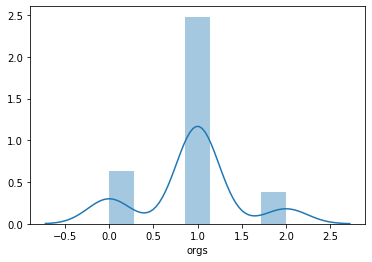

In [1308]:
sns.distplot(orgs['orgs'])

In [1390]:
sns.distplot(orgs['cosine'])

In [1392]:
orgs['cosine'].mean()

0.2877621764348514

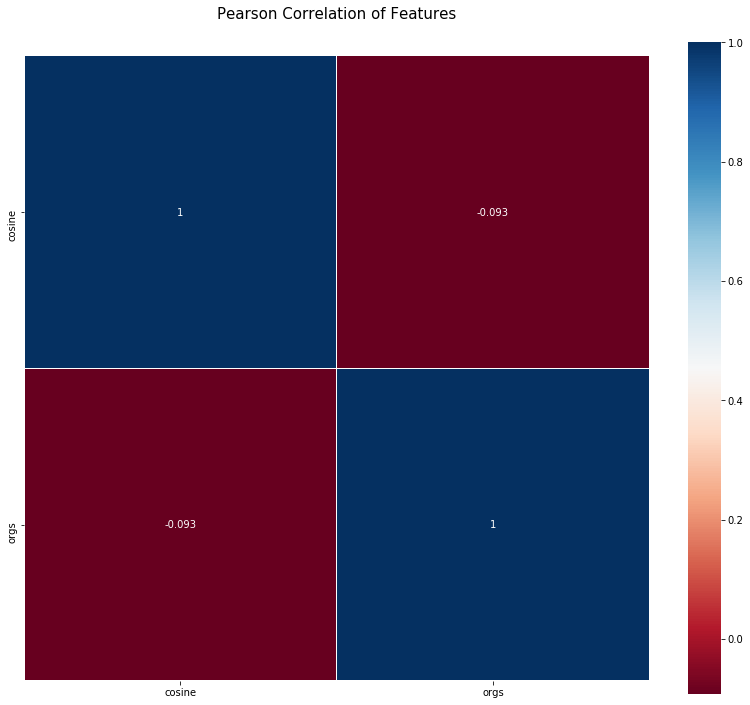

In [1310]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(orgs.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [1311]:
#                orgs, fb, famil, unicorn, hs
# One Feature
final = distance(False,True,False,False,False)
final = distance(False,False,True,False,False)
final = distance(False,False,False,True,False)
final = distance(False,False,False,False,True)

# All Features
#final = distance(True,True,True,True,True)
final.head()

cosine  orgs  fb  famil  unicorn  hs
student1 student2                                        
0        1         0.140757     1   0      1        0   0
         2         0.207999     0   0      0        0   0
         3         0.233300     1   0      1        1   0
         4         0.240674     2   0      2        1   0
         5         0.141350     1   0      1        0   0

In [1312]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(final.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [1313]:
#                orgs, fb, famil, unicorn, hs
final2 = distance(False,True,False,True,True)
final2 = distance(False,False,False,True,True)
final2 = distance(False,True,False,False,True)
final2 = distance(False,True,False,True,False)

# final2 = distance(True,False,False,True,False)

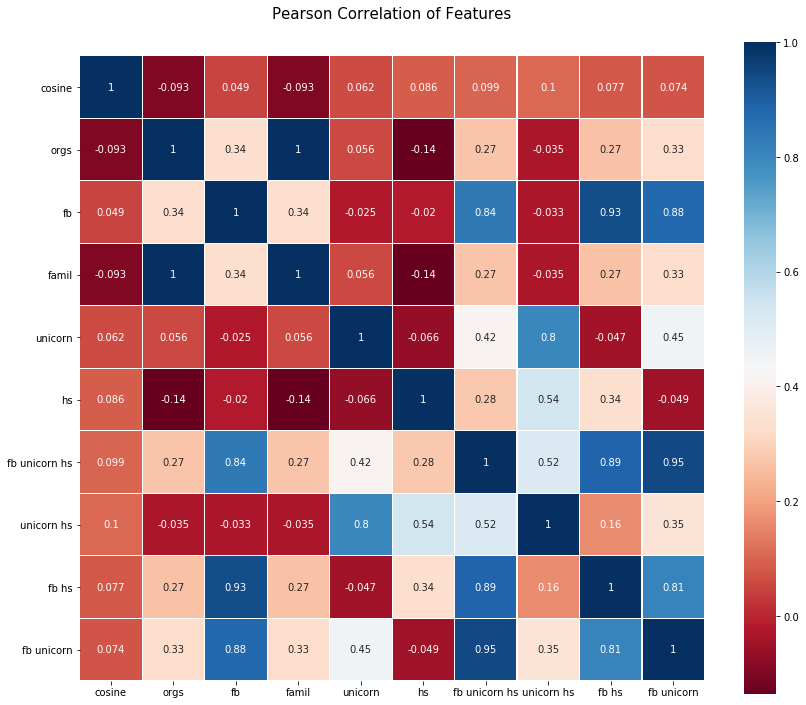

In [1314]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(final2.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [1280]:
list = final['orgs fb famil unicorn hs']


2

In [1359]:
graph = nx.Graph()
for i in range(n):
    graph.add_node(classmates[i])

In [1360]:
graph.add_edge('del_rio','tan',weight=cosine[1][2].round(2))
graph.add_edge('del_rio','tanjangco',weight=cosine[1][3].round(2))
graph.add_edge('tanjangco','tan',weight=cosine[3][2].round(2))
graph.add_edge('del_rio','borja',weight=cosine[1][7].round(2))
graph.add_edge('tan','borja',weight=cosine[2][7].round(2))
graph.add_edge('tanjangco','borja',weight=cosine[3][7].round(2))
graph.add_edge('cuartero','celeres',weight=cosine[4][5].round(2))
graph.add_edge('ng','chua',weight=cosine[8][10].round(2))

{('del_rio', 'tan'): Text(0.6283342868495994, 0.7251363635729413, '0.22'),
 ('del_rio',
  'tanjangco'): Text(0.3494693466251329, 0.7652310964852753, '0.18'),
 ('del_rio', 'borja'): Text(0.09319639942974073, -0.10755440505346597, '0.18'),
 ('tan', 'tanjangco'): Text(0.13655011312622822, 0.9497266930634864, '0.42'),
 ('tan', 'borja'): Text(-0.11972283406916395, 0.07694119152474521, '0.35'),
 ('tanjangco',
  'borja'): Text(-0.39858777429363046, 0.11703592443707916, '0.48'),
 ('cuartero',
  'celeres'): Text(-0.8071768136958359, 0.5187411266125783, '0.31'),
 ('ng', 'chua'): Text(0.3494692274158443, -0.7652311560899197, '0.29')}

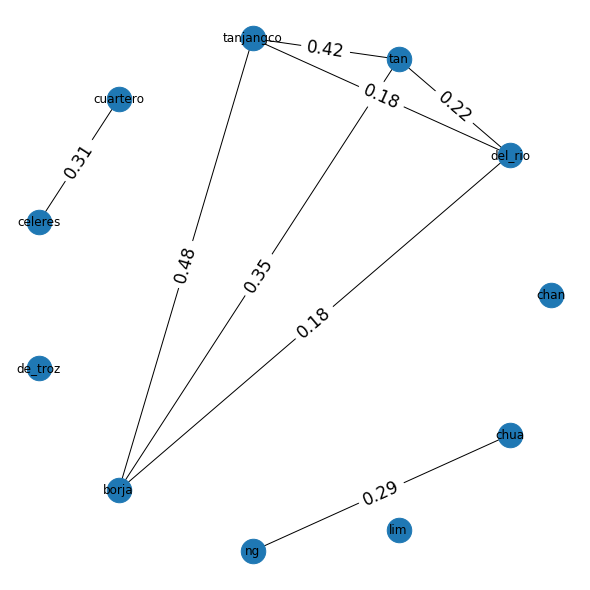

In [1376]:
plt.figure(figsize=(8,8))
pos = nx.circular_layout(graph)
nx.draw(graph, pos, with_labels=True,node_size=600,font_size=12,width=1)
weights = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=weights, font_size=17)

In [1377]:
graph2 = nx.Graph()
for i in range(n):
    graph.add_node(classmates[i])

In [1380]:
one = [1,2,5,7,8]
for i in range(len(one)):
    for j in range(i+1, len(one)):
        graph2.add_edge(classmates[one[i]],classmates[one[j]],weight=cosine[one[i]][one[j]].round(2))
two = [0,3,4,6,9,10]
for i in range(len(two)):
    for j in range(i+1, len(two)):
        graph2.add_edge(classmates[two[i]],classmates[two[j]],weight=cosine[two[i]][two[j]].round(2))

{('del_rio', 'tan'): Text(0.920626760174252, 0.2703203834973651, '0.22'),
 ('del_rio', 'celeres'): Text(0.7077075266753474, 0.4548159800755763, '0.27'),
 ('del_rio', 'borja'): Text(0.42884258645088086, 0.49491071298791023, '0.18'),
 ('del_rio', 'ng'): Text(0.17256966905781085, 0.37787481835315323, '0.23'),
 ('tan', 'celeres'): Text(0.6283342868495994, 0.7251363635729413, '0.21'),
 ('tan', 'borja'): Text(0.3494693466251329, 0.7652310964852753, '0.35'),
 ('tan', 'ng'): Text(0.0931964292320629, 0.6481952018505184, '0.26'),
 ('celeres', 'borja'): Text(0.13655011312622822, 0.9497266930634864, '0.2'),
 ('celeres', 'ng'): Text(-0.11972280426684179, 0.8326907984287295, '0.31'),
 ('borja', 'ng'): Text(-0.3985877444913083, 0.8727855313410635, '0.34'),
 ('chan',
  'tanjangco'): Text(-0.9594929655072936, 2.9802322137895132e-08, '0.23'),
 ('chan', 'cuartero'): Text(-0.8071768434981581, -0.23700848029140603, '0.24'),
 ('chan', 'de_troz'): Text(-0.5509039857097323, -0.3540444047284852, '0.22'),
 ('ch

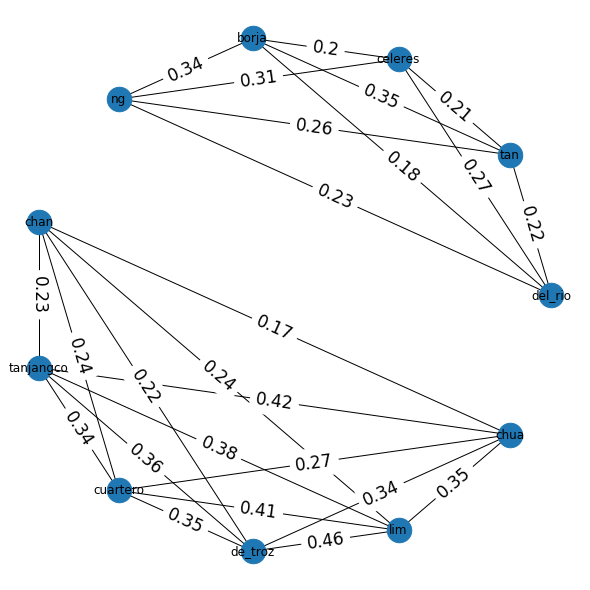

In [1389]:
plt.figure(figsize=(8,8))
pos = nx.circular_layout(graph2)
nx.draw(graph2, pos, with_labels=True,node_size=600,font_size=12,width=1)
weights = nx.get_edge_attributes(graph2, 'weight')
nx.draw_networkx_edge_labels(graph2, pos, edge_labels=weights, font_size=17)
